# PARAMETERS

In [1]:
####### INFERENCE CONFIGURATION

class CFG:
    
    # environment
    environment  = 'local'  # work environment ['kaggle', 'local']
    
    # blending
    scaling     = False
    fold_blend  = 'gmean'  # how to blend folds  ['amean', 'median', 'gmean', 'pmean', 'rmean']
    model_blend = 'gmean'  # how to blend models ['amean', 'median', 'gmean', 'pmean', 'rmean']
    power       = 1e-2     # power parameter for pmean
        
    # paths
    data_path = '../input/'
    out_path  = '../output/blend/'
    
    # models
    models = [
             '../output/v1',
             '../output/v2',
             ]

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### PACKAGES

import numpy as np
import pandas as pd

from scipy.special import softmax
from scipy.stats import gmean

import random
import time
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

In [4]:
####### MODULES

sys.path.append('../code')  

from utilities import get_score, compute_blend

In [5]:
####### ENVIRONMENT SETTINGS

pd.options.display.max_columns = 100  # maximum displayed columns
warnings.filterwarnings('ignore')      # ignoring warnings

# DATA PREP

In [6]:
####### IMPORT OOF PREDS

for m in CFG['models']:

    tmp_train_preds         = pd.read_csv(m + '/oof.csv')
    tmp_train_preds.columns = ['id', 'target', 'file_path', 'fold'] + [str(m) + 'pred']
    
    if CFG['scaling']:
        for fold in range(tmp_train_preds['fold'].max()):
            tmp_train_preds.loc[tmp_train_preds['fold'] == fold, str(m) + 'pred'] = tmp_train_preds.loc[tmp_train_preds['fold'] == fold, str(m) + 'pred'].rank(pct = True)

    if m == CFG['models'][0]:
        train_preds = tmp_train_preds        
    else:
        train_preds = train_preds.merge(tmp_train_preds[['id'] + [str(m) + 'pred']], how = 'left', on = 'id')
        
train_preds.shape

(60000, 6)

In [7]:
####### IMPORT TEST PREDS

for m in CFG['models']:

    tmp_test_preds         = pd.read_csv(m + '/submission.csv')
    tmp_test_preds.columns = ['id'] + [str(m) + p for p in ['pred0', 'pred1', 'pred2', 'pred3', 'pred4']]
    
    if CFG['scaling']:
        for fold in range(5):
            tmp_test_preds[str(m) + 'pred' + str(fold)] = tmp_test_preds[str(m) + 'pred' + str(fold)].rank(pct = True)


    if m == CFG['models'][0]:
        test_preds = tmp_test_preds        
    else:
        test_preds = test_preds.merge(tmp_test_preds[['id'] + [str(m) + p for p in ['pred0', 'pred1', 'pred2', 'pred3', 'pred4']]], how = 'left', on = 'id')
        
test_preds.shape

(39995, 11)

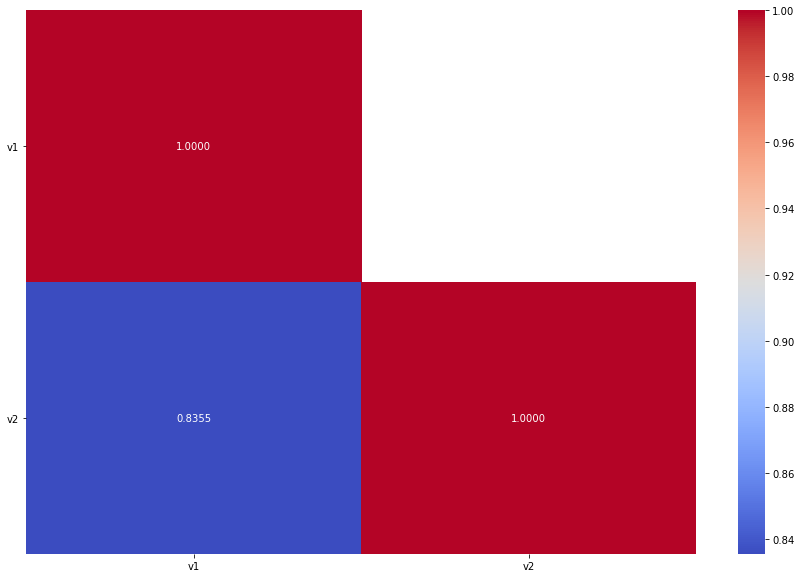

In [8]:
####### CHECK MODEL OOF CORRELATION

# compute correlations
corr    = train_preds[[m + 'pred' for m in CFG['models']]].corr(method = 'spearman')
corr    = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))
fig, ax  = plt.subplots(figsize = (15, 10))
ticks   = [m.replace('../output/', '') for m in CFG['models']]
hmap    = sns.heatmap(corr, cmap = 'coolwarm', annot = corr, fmt = '.4f', xticklabels = ticks, yticklabels = ticks)

# display matrix
plt.yticks(rotation = 0)
plt.savefig(CFG['out_path'] + 'fig_correlation.png')
plt.show()

# BLENDING

In [9]:
####### CHECK MODEL PERFORMANCE

# sort models by performance
weights = []
for model_idx, m in enumerate(CFG['models']):
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds[str(m) + 'pred'].values) / 5
    weights.append(score)
sorted_ids     = list(np.argsort(np.array(weights)))
sorted_weights = [weights[i] for i in sorted_ids]
CFG['models']  = [CFG['models'][i] for i in sorted_ids]

# display performance 
print('-' * 31)
print('{:<5}{:<20}{:>5}'.format('ID', 'Model', 'AUC'))
print('-' * 31)
for model_idx, m in enumerate(CFG['models']):
    print('{:<5}{:<20}{:.4f}'.format(model_idx + 1, m, sorted_weights[model_idx]))
print('-' * 31)

-------------------------------
ID   Model                 AUC
-------------------------------
1    ../output/v2        0.8650
2    ../output/v1        0.8873
-------------------------------


In [10]:
####### CHECK BLEND PERFORMANCE

# custom weights
sorted_weights = [0.2, 0.8]

# compute predcitions
preds = [m + 'pred' for m in CFG['models']]
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    train_preds[blend] = compute_blend(train_preds, preds, blend, CFG)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    train_preds['w' + blend] = compute_blend(train_preds, preds, blend, CFG, weights = np.array(sorted_weights))

# compute performance
print('-' * 16)
print('{:<10}{:>5}'.format('Blend', 'AUC'))
print('-' * 16)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds[blend].values) / 5
    print('{:<10}{:>5.4f}'.format(blend, score))    
print('-' * 16)
for blend in ['amean', 'median', 'gmean', 'pmean', 'rmean']:
    score = 0
    for fold_idx in range(5):
        tmp_train_preds = train_preds.loc[train_preds['fold'] == fold_idx]
        score += get_score(tmp_train_preds['target'].values, 
                           tmp_train_preds['w' + blend].values) / 5
    print('{:<10}{:>5.4f}'.format('w' + blend, score))    
print('-' * 16)

----------------
Blend       AUC
----------------
amean     0.8880
median    0.8880
gmean     0.8875
pmean     0.8875
rmean     0.8811
----------------
wamean    0.8881
wmedian   0.8880
wgmean    0.8882
wpmean    0.8882
wrmean    0.8863
----------------


In [11]:
####### EXPORT BEST BLEND

# blend fold predictions
print('Blending fold predictions with: ' + CFG['fold_blend'])
for m in CFG['models']:
    preds = test_preds.filter(like = m).columns
    test_preds[m + 'pred'] = compute_blend(test_preds, preds, CFG['fold_blend'], CFG)
    test_preds.drop(preds, axis = 1, inplace = True)
    
# blend model predictions
print('Blending model predictions with: ' + CFG['model_blend'])
preds = [m + 'pred' for m in CFG['models']]
test_preds['pred'] = compute_blend(test_preds, preds, CFG['model_blend'], CFG, weights = np.array(sorted_weights))

# save CSV
test_blend = test_preds[['id', 'pred']].copy()   
test_blend.columns = ['id', 'target']
test_blend.to_csv(CFG['out_path'] + 'submission.csv', index = False)
test_blend.head()

Blending fold predictions with: gmean
Blending model predictions with: gmean


,id,target
0,000bf832cae9ff1,0.047284
1,000c74cc71a1140,0.100546
2,000f5f9851161d3,0.027195
3,000f7499e95aba6,0.099656
4,00133ce6ec257f9,0.030714
